In [1]:
### Using PPO (Proximal Policy Optimization) to train PONG agent.

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2
from parallelEnv import parallelEnv
import progressbar as pb

import utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
env = gym.make('PongDeterministic-v4')

In [4]:
env.observation_space #grid-space

Box(210, 160, 3)

In [5]:
env.unwrapped.get_action_meanings() #6 discrete actions

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Preprocess image

In [7]:
state = env.reset()#initial state
print("Initial state shape:", state.shape)

for i in range(20):#play 20 frames
    frame, _, _, _ = env.step(np.random.randint(0, env.action_space.n))

Initial state shape: (210, 160, 3)


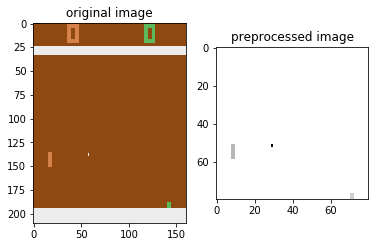

In [8]:
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')
# 80 x 80 black and white image
plt.imshow(uticls.preprocess_single_frame(frame), cmap='Greys')
plt.show()

## Define Policy

In [9]:
# Policy
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        
        ## CNN architecture
        #input_channel = 2 stacked frames, i.e. (80x80x2)
        # outputsize = (inputsize - kernel_size(aka filter_size) + stride)/stride
        # 80x80x2 --> 38x38x4 (Conv1)
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 --> 9x9x16 (Conv2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=4, stride=4, bias=False)
        # TODO: pooling layer
        
        # FC: 9x9x16 -> 9*9*16 = 1296
        self.size = 9*9*16 #1296
        
        #FC layers
        self.fc1 = nn.Linear(in_features=self.size, out_features=256)#standard model
        self.fc2 = nn.Linear(in_features=256, out_features=1) #1 action, left or right
        
        # define sigmoid for output layer (classification problem, essentially)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        """
        Performs feed forward one-pass convolution for a frame based on the following CNN architecture.
        80x80x2 --> 38x38x4 (Conv)
        38x38x4 --> 9x9x16  (Conv)
        1296 --> 256        (FC)
        256 --> 1           (FC)
        sigmoid(1)          (output)
        ----------
        @Param:
        1. x: 2 stacked frames of shape: (80x80x2)
        @Return:
        - out: probability of action (stochastic)
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size) #flatten
        x = F.relu(self.fc1(x))
        out = self.sigmoid(self.fc2(x)) #stochastic
        return out

In [10]:
policy = Policy()

In [11]:
print(policy) #model architecture

Policy(
  (conv1): Conv2d(2, 4, kernel_size=(6, 6), stride=(2, 2), bias=False)
  (conv2): Conv2d(4, 16, kernel_size=(4, 4), stride=(4, 4), bias=False)
  (fc1): Linear(in_features=1296, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [12]:
optimizer = optim.Adam(policy.parameters(), lr=1e-4) #Adam

# PPO

#### Part 1: Clipped Surrogate Function

![Surrogate Function](https://miro.medium.com/max/1400/1*9pJbEtLftES-kgKeonxUYQ.png)

![importance sampling ratio](https://i.stack.imgur.com/bCAEy.png)
<br>
![formula for clipped surrogate function](https://i.stack.imgur.com/zt9mz.png)

### Part 2. Training

In [104]:
# keep track of how long training takes

# training loop max iterations
episode = 500

# widget bar to display progress
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

#load mulitple parallel agents
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        SAR = (states, actions, rewards)
        L = -utils.clipped_surrogate(policy, old_probs, SAR, epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 50 iterations
    if (e+1)%50 == 0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

training loop: 100% |###########################################| Time: 0:00:37


In [60]:
env.reset()
R = []
for i in range(1000):#play 20 frames
    frame, r, done, _ = env.step(np.random.randint(4, env.action_space.n))
    env.render()
    R.append(r)
    if(done):
        break

In [35]:
RIGHT = 4; LEFT = 5

In [36]:
import time

In [54]:
env.reset()
env.step(1)
total_reward = 0
time.sleep(10)
# perform nrand random steps in the beginning
for _ in range(5):
    frame1, reward1, is_done, _ = env.step(np.random.choice([RIGHT,LEFT]))
    frame2, reward2, is_done, _ = env.step(0)

for _ in range(3000):

    frame_input = utils.preprocess_batch([frame1, frame2])
    prob = policy(frame_input)
#     time.sleep(0.05)

    # RIGHT = 4, LEFT = 5
    action = RIGHT if np.random.rand() < prob else LEFT
    frame1, r, is_done, _ = env.step(action)
    frame2, _, is_done, _ = env.step(0)
    total_reward += r
    env.render()

    if is_done:
        break
        
print(total_reward)

-1.0


# Save model weights

In [97]:
torch.save(policy.state_dict(), "model_2.pth")

In [13]:
load_weights = torch.load("model_2.pth")

In [14]:
policy.load_state_dict(load_weights)

In [108]:
param = np.array(list(policy.parameters()))

In [114]:
print(f"Trained on {len(mean_rewards)} episodes, mean score of (last 50 ep.): {np.array(mean_rewards[-50:]).mean()}")

Trained on 519 episodes, mean score of (last 50 ep.): 4.4425


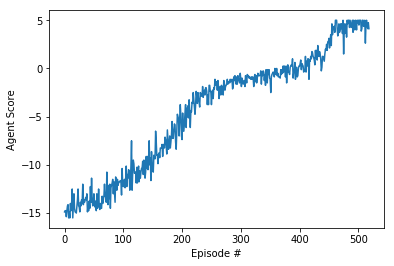

In [107]:
plt.plot(mean_rewards)
plt.xlabel("Episode #")
plt.ylabel("Agent Score")
plt.show()

## SOLVED!